## Setup

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
import torch                                        # root package
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using {device} device')

Using cuda device


# 01 Pytorch workflow

General workflow:

1.   Data (prepare and load)
2.   Build model
3. Fitting
4. Predictions
5. Saving and loading model
6. Putting all of the above together.

## Data

In [7]:
# known line , this is what we'll try to estimate.
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

#data
X = torch.arange(start,end,step,device=device).unsqueeze(dim=1)
y = bias + weight*X

#test-train splitting
train_split = int(0.8 * len(X))

X_train,y_train = X[:train_split],y[:train_split]
X_test,y_test = X[train_split:],y[train_split:]

#visualization
def visualize(train_data=X_train,train_labels=y_train,test_data=X_test,test_labels=y_test,predictions=None):
    plt.scatter(train_data.cpu(),train_labels.cpu(),c="g",s=8,label="Training")
    plt.scatter(test_data.cpu(),test_labels.cpu(),c="b",s=8,label="Testing")
    if predictions is not None:
        plt.plot(test_data.cpu(),predictions.cpu(),c="r",label="Predictions")
    plt.legend()
    plt.show()

def visualize_full(train_data=X_train,train_labels=y_train,test_data=X_test,test_labels=y_test,predictions=None):
    plt.scatter(train_data.cpu(),train_labels.cpu(),c="g",s=8,label="Training")
    plt.scatter(test_data.cpu(),test_labels.cpu(),c="b",s=8,label="Testing")
    if predictions is not None:
        plt.plot(X.cpu(),predictions.cpu(),c="r",label="Predictions")
    plt.legend()
    plt.show()

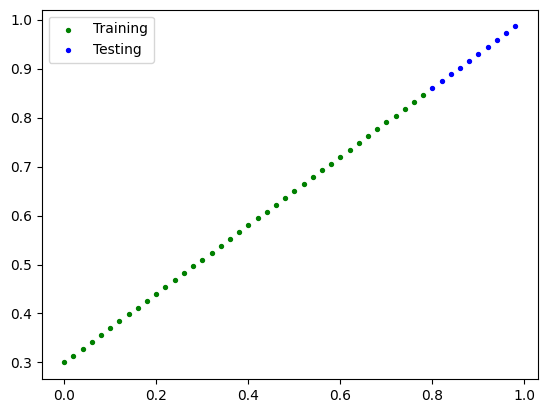

In [8]:
visualize()

## PyTorch model

Stuff mainly used:

1. `torch.nn` - Contains building blocks for computational graphs
2. `torch.nn.Parameter`
3. `torch.nn.Module` - base class for NN modules
4. `torch.optim` - Helps with gradient descent
5. `def forward()`

In [9]:
class LinearRegressionModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.weights = nn.Parameter(torch.rand(1,requires_grad=True,dtype=torch.float,device=device))
        self.bias = nn.Parameter(torch.rand(1,requires_grad=True,dtype=torch.float,device=device))

    def forward(self,x: torch.tensor) -> torch.tensor:
        return self.weights*x + self.bias

In [27]:
RANDOM_SEED = 42 #for reproducability
torch.manual_seed(RANDOM_SEED)

model_0 = LinearRegressionModel().to(device)

In [28]:
print(list(model_0.parameters()))
print("------")
for i,j in (dict(model_0.state_dict())).items():
    print(i,": ",j)

[Parameter containing:
tensor([0.6130], device='cuda:0', requires_grad=True), Parameter containing:
tensor([0.9877], device='cuda:0', requires_grad=True)]
------
weights :  tensor([0.6130], device='cuda:0')
bias :  tensor([0.9877], device='cuda:0')


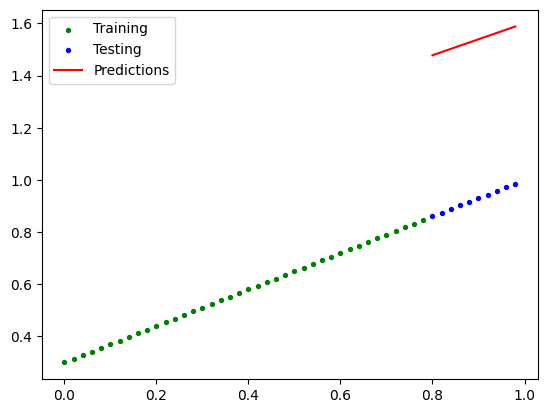

In [29]:
with torch.inference_mode():#removes all the gradients
    y_preds = model_0(X_test)

visualize(predictions=y_preds)

### Loss function and optimizer

In [30]:
loss_fn = nn.L1Loss().to(device)
#stochastic gradient descent
optimizer = optim.SGD(params=model_0.parameters(),
                      lr=0.005)

### Training & testing loop

Epochs are the iterations through the data, this is a hyperparameter.

Training mode in PyTorch sets the gradients and starts to keep track of them.
Eval mode turns it off.

1. `optimizer.zero_grad()`:
Zeros the optimizer change so that it doesn't accumulate.
Some complex reason for the accumulation, bleh.
2. `loss.backward()`:
Backpropagation
3. `optimizer.step()`:
Optimizing the parameters.

In [31]:
%time

epochs = 200
train_losses = []
test_losses = []
ws = []
bs = []

for epoch in range(epochs):
    model_0.train()
    y_pred = model_0(X_train) #forward pass
    loss = loss_fn(y_pred,y_train) #loss: input,target
    optimizer.zero_grad() #Gradient set to zero
    loss.backward() #Backpropagation, gives gradient
    optimizer.step() #Optimization

    model_0.eval()
    with torch.inference_mode():
        y_test_pred = model_0(X_test)
        loss_test = loss_fn(y_test_pred,y_test)
    
    train_losses.append(float(eval(f"{loss:.4f}")))
    test_losses.append(float(eval(f"{loss_test:.4f}")))
    state_dict = dict(model_0.state_dict())
    ws.append(state_dict["weights"].item())
    bs.append(state_dict["bias"].item())

CPU times: total: 0 ns
Wall time: 0 ns


### Statistics of performance

Final training loss: 0.0452
Final testing loss: 0.1052


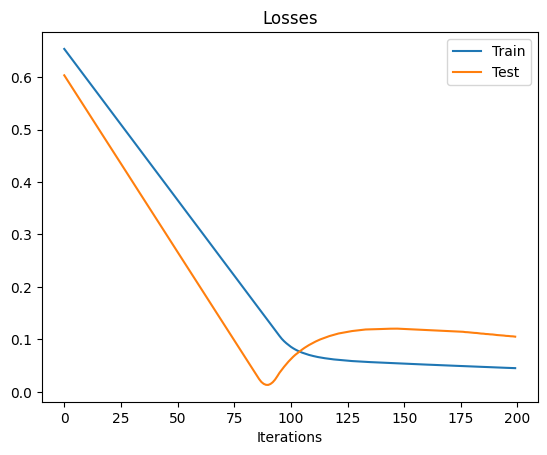

Final weight: 0.4761888086795807
Final bias: 0.39396926760673523


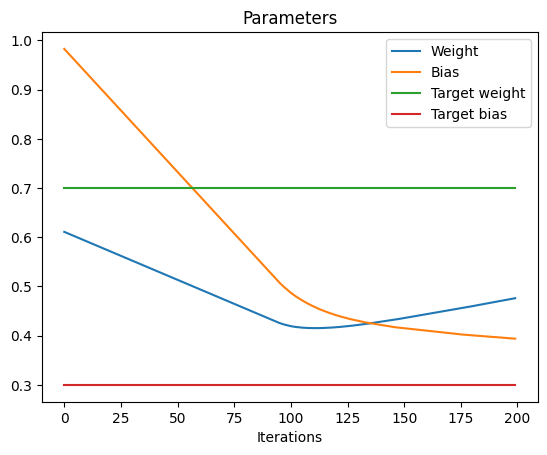

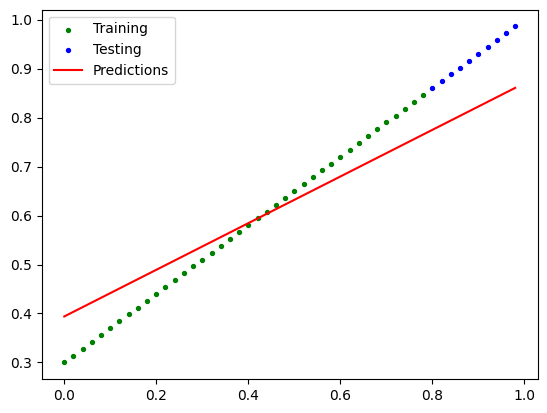

In [32]:
print(f"Final training loss: {loss:.4f}")
print(f"Final testing loss: {loss_test:.4f}")

plt.plot(train_losses,label="Train")
plt.plot(test_losses,label="Test")
plt.legend()
plt.title("Losses")
plt.xlabel("Iterations")
plt.show()

print(f"Final weight: {state_dict['weights'].item()}")
print(f"Final bias: {state_dict['bias'].item()}")

plt.plot(ws,label="Weight")
plt.plot(bs,label="Bias")
plt.plot(np.ones(epochs)*weight,label="Target weight")
plt.plot(np.ones(epochs)*bias,label="Target bias")
plt.legend()
plt.title("Parameters")
plt.xlabel("Iterations")
plt.show()

with torch.inference_mode(): #torch.no_grad() also works
    y_pred = model_0(X)
visualize_full(predictions=y_pred)

### Saving models

Refer: https://pytorch.org/tutorials/beginner/saving_loading_models.html

Three main things to know:
1. `torch.save()` - Pickle format save
2. `torch.load()` - Load a saved pickle format
3. `torch.nn.Module.load_state_dict()` - Loads a model's saved state dictionary

In [33]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)
MODEL_NAME = "model_0_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(model_0.state_dict(),MODEL_SAVE_PATH)

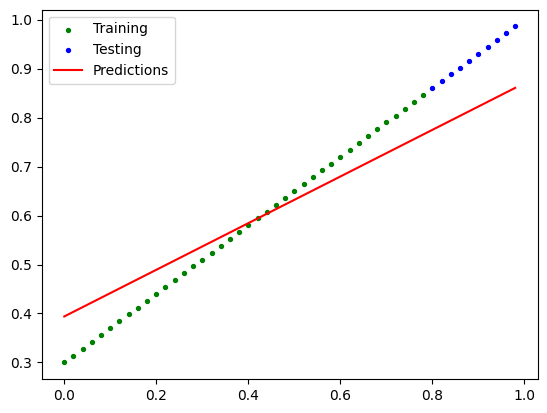

In [34]:
model_0_load = LinearRegressionModel()
model_0_load.load_state_dict(torch.load(MODEL_SAVE_PATH))

with torch.inference_mode():
    predictions = model_0_load(X)

visualize_full(predictions=predictions)

## V2

`nn.Linear` gives a function which applies the transformation as follows:
$$y = xA^T + b$$
where A and b have their sizes defined as in_features and out_features respectively

Final training loss: 0.0063
Final testing loss: 0.0143


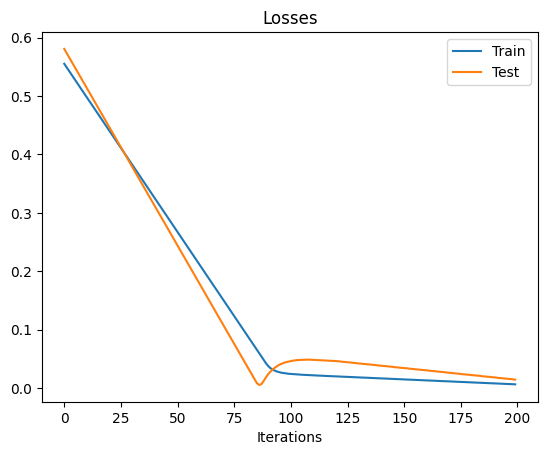

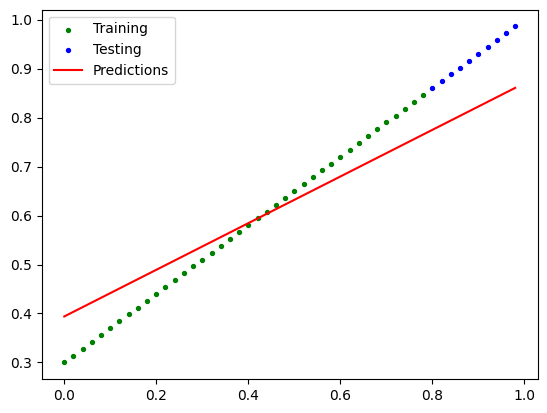

linear_layer.weight :  tensor([[0.6693]], device='cuda:0')
linear_layer.bias :  tensor([0.3130], device='cuda:0')
Saved.
Loaded.


In [35]:
#data is same as before

class LinearRegressionModel_2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)
    
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

#reproducability    
torch.manual_seed(42)
model_1 = LinearRegressionModel_2()

#agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
model_1.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)

#loss function and optimizer
loss_fn = nn.L1Loss().to(device)
optimizer = optim.SGD(params=model_1.parameters(),
                      lr = 0.005)

#training loop
torch.manual_seed(42)

epochs = 200
train_losses = []
test_losses = []

for epoch in range(epochs):
    model_1.train()
    y = model_1(X_train)
    loss = loss_fn(y, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        y_pred = model_1(X_test)
        loss_test = loss_fn(y_pred,y_test)

    train_losses.append(eval(f"{loss:.4f}"))
    test_losses.append(eval(f"{loss_test:.4f}"))

#Statistics
print(f"Final training loss: {loss:.4f}")
print(f"Final testing loss: {loss_test:.4f}")

plt.plot(train_losses,label="Train")
plt.plot(test_losses,label="Test")
plt.legend()
plt.title("Losses")
plt.xlabel("Iterations")
plt.show()

with torch.inference_mode():
    y_pred = model_0(X)
visualize_full(predictions=y_pred)

for i,j in dict(model_1.state_dict()).items():
    print(i,": ",j)

#saving
try:
    MODEL_PATH = Path("models")
    MODEL_PATH.mkdir(parents=True,exist_ok=True)
    MODEL_NAME = "model_1_0.pth"
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
    torch.save(obj=model_1.state_dict(),
               f=MODEL_SAVE_PATH)
    print("Saved.")
except:
    print("Error saving.")

#loading
try:
    model_1_load = LinearRegressionModel_2()
    model_1_load.load_state_dict(torch.load(MODEL_SAVE_PATH))
    model_1_load.to(device)
    print("Loaded.")
except:
    print("Error loading.")